In [1]:
"""This notebook is designed to retrieve 16s data from One Codex and perform differential abundance analysis between cohorts of mice treated
with various drug products over a timecourse.  """
"""Importing modules"""
import pandas as pd
import os
import numpy as np
import argparse
from onecodex import Api
import functools
import seaborn as sns
import json
# import ecopy as ep
from skbio.stats.composition import ancom
from skbio.stats.ordination import pcoa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
import matplotlib
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline


2022-04-08 08:45:16,604 WARNING: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [38]:
"""Setting Box directory"""
data_dir = '/Users/home/data/'
results_dir = '/Users/home/results/'

In [3]:
# """Finding samples"""
ocx = Api('API-KEY')
all_samples = ocx.Samples.all()

<Samples 3bddcfd9f0d24bc6: "_1.fastq.gz">

In [4]:
"""Accessing samples by project"""
project = ocx.Projects.get('PROJECT_ID')
samples = ocx.Samples.where(project=project.id)

In [5]:
"""checking that correct samples have been pulled and metadata is complete"""
print(len(samples))
one_sample = ocx.Samples.get('ONE_SAMPLE_ID')
print(one_sample.metadata.custom)
print(one_sample.metadata.name)
"""Looking at metadata columns present in One Codex Data"""
samples.metadata[['external_sample_id', 'description', 'drug']]
"""
external_sample_id = subject id
description = timepoint
drug = treatment"""

75
{'drug': 'EXP1706_GI', 'mouse': 20}
20_B.fastq.gz


                    shannon external_sample_id description        drug  \
classification_id                                                        
0afce8316ec9493e   2.628113                  9     washout      EXP894   
e15037eabb9049d1   2.819817                 24     washout       ES880   
4ae05fa234d74ab4   3.866169                 19     washout  EXP1706_GI   
dcef8d97da764edf   3.408990                  3     washout     vehicle   
d4398701d9b24472   3.353413                  2     washout     vehicle   

                            combination  
classification_id                        
0afce8316ec9493e       washout / EXP894  
e15037eabb9049d1        washout / ES880  
4ae05fa234d74ab4   washout / EXP1706_GI  
dcef8d97da764edf      washout / vehicle  
d4398701d9b24472      washout / vehicle  


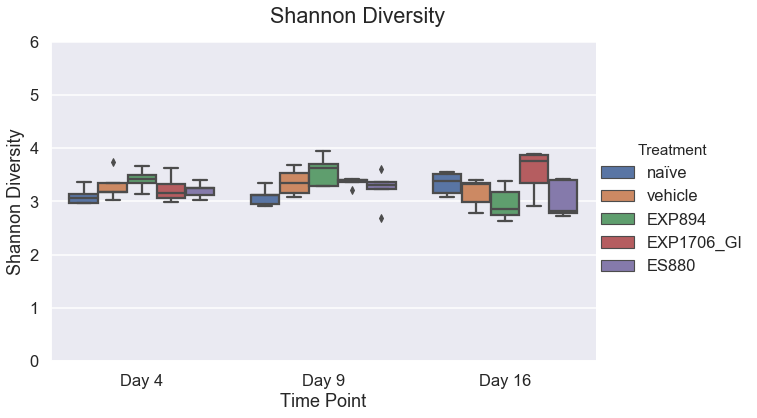

In [31]:
"""Getting Shannon Diversity and generating boxplots based on timepoint and treatment"""
shannon_diversity = samples.alpha_diversity('shannon')
shannon_diversity = shannon_diversity.merge(samples.metadata[['external_sample_id', 'description', 'drug']], left_index=True, 
                                           right_index=True)
sns.set(context='talk', style='darkgrid')
def shannon_plots(shannon_frame):
    
    plot_df = shannon_frame
    plot_df.sort_values(by='description', inplace=True, ascending=False)
    """Setting order of timepoints"""
    category_order = ['time_x', 'time_y', 'time_z']
    print(plot_df.head())
    g = sns.catplot(y='shannon', x='description', data=plot_df[['shannon', 'description', 'drug']], hue='drug', 
               kind='box', height=6, aspect=6/4, hue_order=['trt_1', 'trt_2', 'trt_3', 'trt_4', 'trt_5'],
                   order=category_order)
    g.axes[0,0].set(ylim=(0,6))
    g.set_xticklabels(['Day x', 'Day y', 'Day z'])
    g.fig.suptitle(str('Shannon Diversity'))
    g.axes[0,0].set_xlabel('Time Point')
    g.axes[0,0].set_ylabel('Shannon Diversity')
    g.fig.subplots_adjust(top=.9)
    g._legend.set_title('Treatment')
    plt.savefig(results_dir + 'plots/Shannon_Diversity_box.png')


shannon_plots(shannon_diversity)

In [ ]:
samples.plot_mds(method='pcoa', metric='braycurtis', color='drug')

In [48]:
"""Running 2 way anova with post hoc tukey test"""
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model = ols('shannon ~ C(description) + C(drug) + C(description):C(drug)', data=shannon_diversity).fit()
sm.stats.anova_lm(model, typ=2)
shannon_diversity['combination'] = shannon_diversity.description + " / " + shannon_diversity.drug

m_comp = pairwise_tukeyhsd(endog=shannon_diversity['shannon'], groups=shannon_diversity['combination'], alpha=0.05)

tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])

sig_results = tukey_data[tukey_data['reject'] == True]


,group1,group2,meandiff,p-adj,lower,upper,reject
81,during_dose / EXP894,washout / EXP894,-0.6169,0.0317,-1.2063,-0.0276,True
99,washout / EXP1706_GI,washout / EXP894,-0.6008,0.0415,-1.1902,-0.0115,True


In [16]:
"""Defining functions to create the tables that can be used in ANCOM and as a summary output"""

"""Putting the readcount tables into a dictionary and filtering. Filters on minimum readcount and taxonomic rank.  
Genus or Family is appropriate for this 16S method."""
def get_sample_dfs(sample_list, min_readcount, rank):
    sample_dict = {}
    for i in range(len(sample_list)):
        """Need to define the name for this sample"""
        sample_id = sample_list[i].metadata.name.replace('.fastq.gz', '')
        
        readcount_table = sample_list[i].primary_classification.table()[['name', 'rank', 'readcount_w_children']]
        readcount_table = readcount_table[readcount_table['rank'] == rank]
        readcount_table = readcount_table[readcount_table['readcount_w_children'] >= min_readcount]
        readcount_table = readcount_table[['name', 'readcount_w_children']]
        """ANCOM needs the readcount column to be renamed to the sample it belongs to"""
        readcount_table.columns = ['classification', sample_id]
        readcount_table.set_index('classification', inplace=True)
        sample_dict[sample_id] = readcount_table
    return sample_dict

"""Merging readcount dfs from the dictionary.  Used to create df for ANCOM (need to remove missing numbers before running ANCOM)"""
def dataframe_dict_merge(dict_dataframes):
    key_list = list(dict_dataframes.keys())    
    readcount_dfs = [dict_dataframes[x] for x in key_list]
    merged_function_dfs = functools.reduce(lambda left,right: pd.merge(left,right, right_index=True, left_index=True, 
                                                                      how='outer'), readcount_dfs)
    merged_function_dfs.columns = key_list
    merged_function_dfs.fillna(1, inplace=True)
    ancom_df = merged_function_dfs.copy()
    
    """Creates a multi index by splitting the name strings."""
    idx = merged_function_dfs.columns.str.rsplit('_', expand=True)
    merged_function_dfs.columns = idx
    merged_function_dfs.sort_index(level=0, axis=1, inplace=True)
    return merged_function_dfs, ancom_df

"""Collapse readcounts on sample and get percent composition for samples"""
def count_by_sample(merged_frame):
    """getting sample names which should be level 0"""
    sample_names = list(merged_frame.columns.levels[0])
    """allocating df"""
    all_counts = pd.DataFrame()
    for i in sample_names:
        sample_count = merged_frame.groupby(level=0, axis=1).sum()[i].sort_values(ascending=False).reset_index()
        sample_count['percentage'] = (sample_count[i] / sample_count[i].sum()) * 100
        sample_count.columns = [str(i + '_Classification'), str(i + '_ReadCount'), str(i + '_PercentComposition')]
        sample_count = sample_count.head(20)
        all_counts = pd.concat([sample_count, all_counts], axis=1)
    idx = all_counts.columns.str.split('_', expand=True)
    all_counts.columns=idx
    all_counts.sort_index(level=0, axis=1, inplace=True)

    return all_counts


"""Present percent composition by timepoints for all samples"""
def count_by_timepoint(merged_frame):
    """get sample name and timepoints"""
    sample_names = merged_frame.columns.levels[0]
    time_points = merged_frame.columns.levels[1]
    #print(time_points)
    """allocating df"""
    all_counts = pd.DataFrame()
    for i in sample_names:
        for k in time_points:
            sample_count = merged_frame[i][k].sort_values(ascending=False).reset_index()
            sample_count['percentage'] = (sample_count[k] / sample_count[k].sum()) * 100
            sample_count.columns = [str(i + '_' + k + '_Classification'), str(i + '_' + k + '_ReadCount'), 
                                    str(i + '_' + k + '_PercentComposition')]
            sample_count = sample_count.head(20)
            #print(x)
            all_counts = pd.concat([sample_count, all_counts], axis=1)

    idx = all_counts.columns.str.split('_', expand=True)
    all_counts.columns=idx
    all_counts.sort_index(level=0, axis=1, inplace=True)
    return all_counts

            
merged_frame, ancom_df = dataframe_dict_merge(get_sample_dfs(samples, 10, 'genus'))
time_point_count_frame = count_by_timepoint(merged_frame)
sample_count_frame = count_by_sample(merged_frame)


In [22]:
"""ANCOM Calculations, creating multiple groupings for later in the analysis.  Need a df specifically for ANCOM
ANCOM does not like 1 counts, specifiy a minimum of 10 in the ancom generating function"""
time_grouping = pd.Series(list(x.metadata.description for x in samples), 
                     index=list(x.metadata.name.replace('.fastq.gz', '') for x in samples))
sample_grouping = pd.Series(list(x.metadata.external_sample_id for x in samples), 
                     index=list(x.metadata.name.replace('.fastq.gz', '') for x in samples))
drug_grouping = pd.Series(list(x.metadata.custom['drug'] for x in samples),
                         index=list(x.metadata.name.replace('.fastq.gz', '') for x in samples))


results = ancom(ancom_df.transpose(), drug_grouping)


results[results['W'] > 0]
"""Alternate ways of selecting for differentially abundant genera"""
bacterial_list = results[results['reject'] == True].index.tolist()
bacterial_list = results[results['W'] > 5].index.tolist()


2021-03-25 09:58:16,509 WARNING: invalid value encountered in double_scalars
2021-03-25 09:58:18,193 WARNING: invalid value encountered in less


In [24]:
"""Setting up ancom metadata frame for downstream pivot table and possible multiple comparisons"""
time_grouping_df = pd.DataFrame(time_grouping)
sample_df = pd.DataFrame(sample_grouping)
drug_df = pd.DataFrame(drug_grouping)
ancom_metadata = pd.merge(time_grouping_df, sample_df, left_index=True, right_index=True)
ancom_metadata = pd.merge(ancom_metadata, drug_df, left_index=True, right_index=True)
ancom_metadata.columns = ['description', 'external_sample_id', 'drug']
ancom_metadata['category'] = 'bacteria'
ancom_metadata.loc[ancom_metadata['drug'] == 'vehicle', ['category']] = 'vehicle'
ancom_metadata.loc[ancom_metadata['drug'] == 'naïve', ['category']] = 'naïve'
# ancom_metadata.head(40)

In [26]:
def get_ancom(ancom_df, metadata, comparison):
    """comparison should be either drug or category comparison"""    
    """comparision dict for between comparators at the three timepoints"""
    comparator_dict = {}
    """comparison dict for within comparator timepoints"""
    timepoint_dict = {}
#     ancom_results_dict = {}
    comparison_list = metadata[comparison].unique().tolist()
    
    """Getting between comparator ancom for the all timepoints"""
    for i in ['time_x', 'time_y', 'time_z']:
        print(i)
        subset_meta = metadata[metadata['description'] == i].copy()
        print(len(subset_meta))
        grouping = pd.Series(subset_meta[comparison])
        print(len(grouping))
        column_list = grouping.index.tolist()
        subset_ancom = ancom_df[column_list]
        print(len(subset_ancom.T))
        name_string = str(comparison + '_' + str(i))
        print(name_string)
        comparator_dict[name_string] = ancom(subset_ancom.transpose(), grouping)
    
    for i in comparison_list:
        """Within category comaprison for the three timepoints"""
        """Getting the metadata columns for comparison, and then using these to pull out
        the proper columns from the larger ancom df to run ancom on again"""
        subset_meta = metadata[metadata[comparison] == i]
        grouping = pd.Series(subset_meta['description'])
        column_list = grouping.index.tolist()
        subset_ancom = ancom_df[column_list]
        name_string = str('within_' + str(i))
        print(name_string)
        """Saving Ancom results to dictionary"""
        timepoint_dict[name_string] = ancom(subset_ancom.transpose(), grouping)
                
        

    return comparator_dict, timepoint_dict


comparator_dict, timepoint_dict = get_ancom(ancom_df, ancom_metadata, 'drug')

before_dose
25
25
25
drug_before_dose
during_dose
25
25
25
drug_during_dose
washout
25
25
25
drug_washout
within_EXP894
within_EXP1706_GI
within_vehicle
within_ES880
within_naïve


,description,external_sample_id,drug,category
10_B,during_dose,10,EXP894,bacteria
10_A,before_dose,10,EXP894,bacteria


during_dose 23
before_dose 18
washout 5
EXP894 5
EXP1706_GI 14
vehicle 11
ES880 3
naïve 6


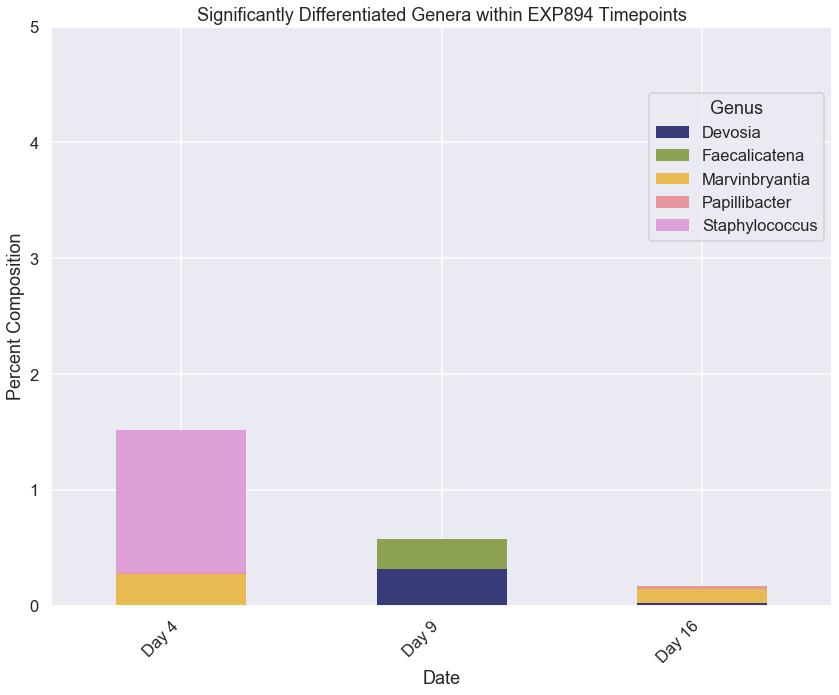

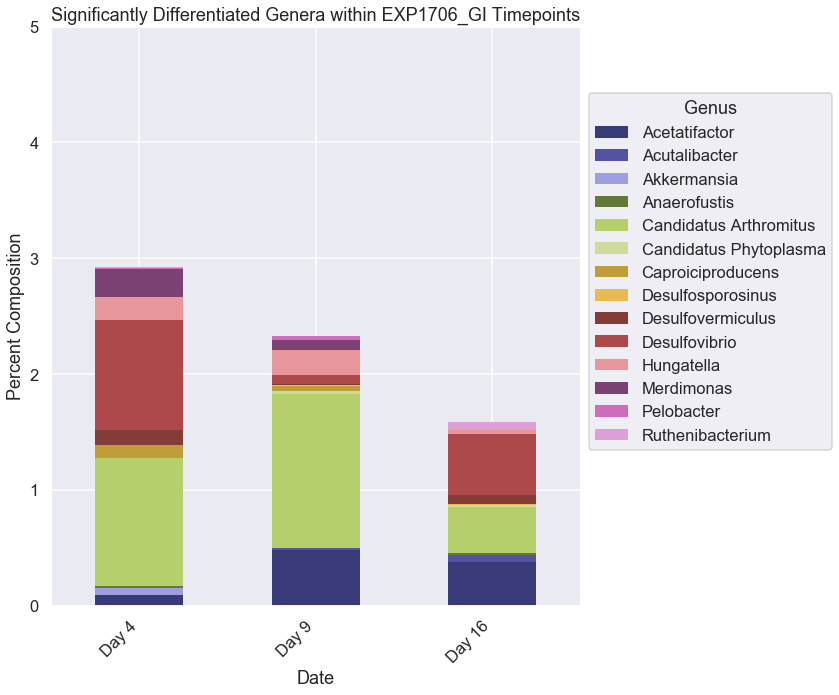

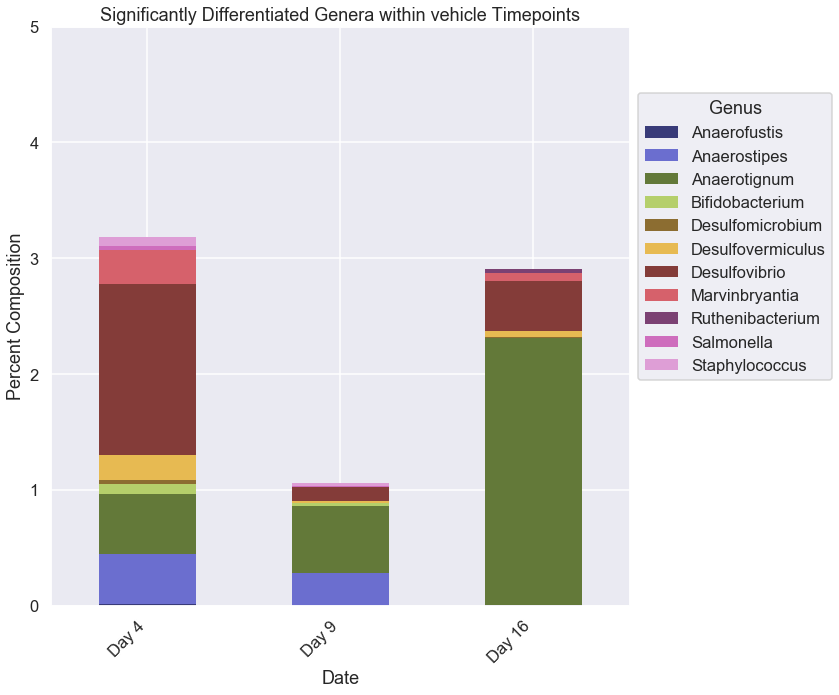

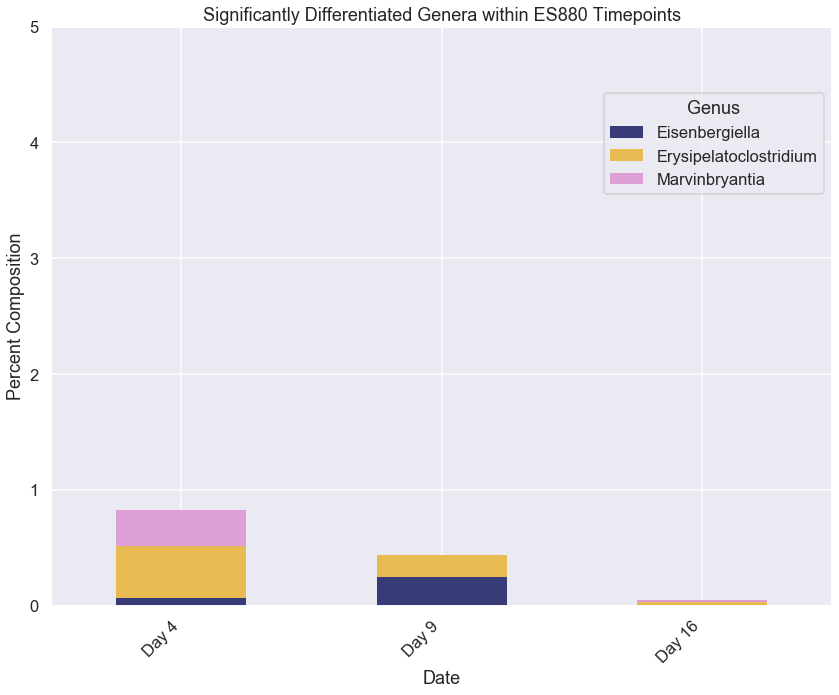

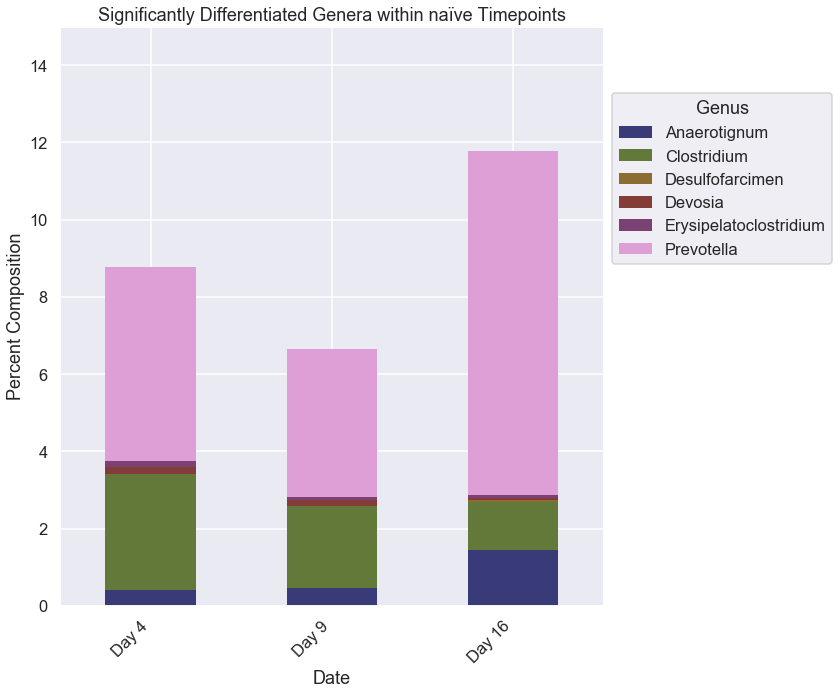

In [29]:
"""Using ANCOM results generate barplots of significantly differentiated genera for both within timepoint comparisons of treatment, and 
withing sample comparisons accross timepoint"""

def get_ancom_summary(comparator_dict, timepoint_dict, ancom_df, metadata, comparison):
    
    """Dicts of results where ancom is true and the sig genera summarized by grouping"""
    comparator_summary = {}
    timepoint_summary = {}
    time_point_list = metadata['description'].unique().tolist()
    comparison_list = metadata[comparison].unique().tolist()
    """Pivot ancom df into right format"""
    merged_ancom = ancom_df.T.merge(ancom_metadata[['description', 'external_sample_id', 'drug', 
                                                    'category']], left_index=True, right_index=True, how='left')
    pivoted = merged_ancom.pivot_table(index=['drug', 'description']).T
    pivoted = (pivoted / pivoted.sum(axis=0)) * 100
    
    """Getting within timepoint comparisons for differentiated genera between treatments"""
    for i in time_point_list: 
        day = ''
        results_frame = comparator_dict[str(comparison + '_' + i)]
        sig_genera = results_frame[results_frame['reject'] == True].index.tolist()
        print(i, len(sig_genera))
        sig_frame = pivoted.loc[sig_genera]
        comparator_summary[(str(comparison + '_' + i))] = sig_frame.loc[:, sig_frame.columns.get_level_values(1).isin([i])]
    
    """Getting within sample diff across timepoints"""
    for i in comparison_list:
        day = ''
        results_frame = timepoint_dict[str('within_' + i)]
        sig_genera = results_frame[results_frame['reject'] == True].index.tolist()
        print(i, len(sig_genera))
        sig_frame = pivoted.loc[sig_genera]
        timepoint_summary[(str('within_' + i))] = sig_frame.loc[:, sig_frame.columns.get_level_values(0).isin([i])]
#         print(sig_genera)
#         print(timepoint_summary[(str('within_' + i))])
        ax = timepoint_summary[(str('within_' + i))].T.plot(kind='bar', stacked=True, figsize=(12,10), 
                                                                    edgecolor='none', cmap='tab20b')

        ax.set_xticklabels(['Day X',  
                            'Day Y',  
                            'Day Z', ], rotation = 45, ha='right')
        ax.legend(bbox_to_anchor=(1,0.9), title='Genus')

        ax.set_ylabel('Percent Composition')
        ax.set_xlabel('Date')
        ax.set_title('Significantly Differentiated Genera within ' + i + ' Timepoints')
        ax.set_ylim(0,5)    
        plt.tight_layout()
        plt.savefig(results_dir + 'plots/sig_diff_genera_' + i + '_timepoints.png')
    return comparator_summary, timepoint_summary
comparator_results, timepoint_results = get_ancom_summary(comparator_dict, timepoint_dict, ancom_df, ancom_metadata, 'drug')

In [32]:
"""Getting top genera by cohort, dose, timepoint using pivot table"""

ancom_meta_merged = ancom_df.T.merge(ancom_metadata[['description', 'external_sample_id', 'drug', 'category']], left_index=True, right_index=True, how='left')
pivoted = ancom_meta_merged.pivot_table(index=['drug', 'description']).T
pivoted = (pivoted / pivoted.sum(axis=0)) * 100
comp_frame = pd.DataFrame()
for col in pivoted.columns.sort_values(ascending=False):
    temp_frame = pd.DataFrame(pivoted[col].nlargest(20).reset_index())
    comp_frame = comp_frame.merge(temp_frame, left_index=True, right_index=True, how='right')

    
comp_frame.to_excel(results_dir + 'tables/all_samples_sumary_top20.xlsx')

2021-03-25 09:58:34,228 WARNING: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)


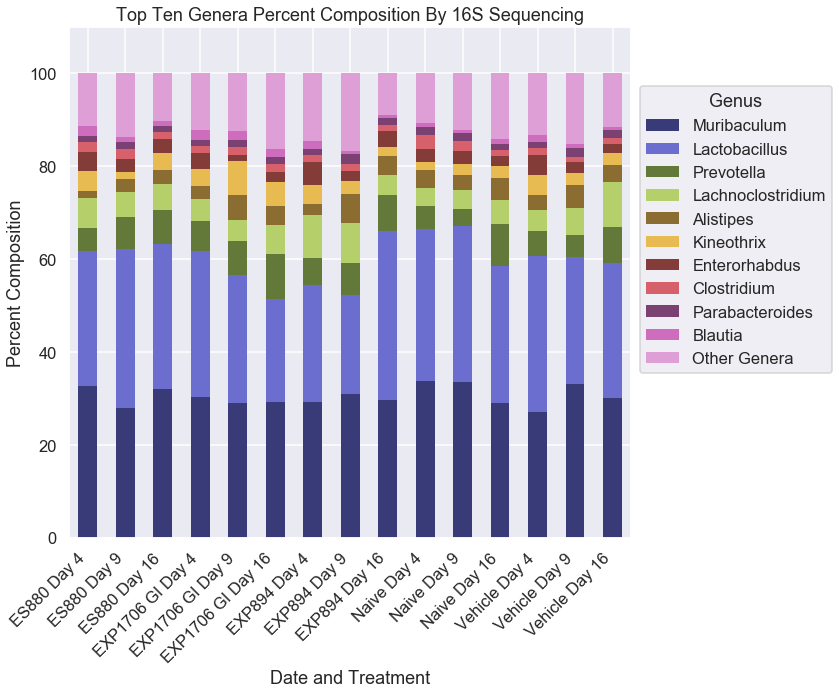

In [35]:
"""Plotting top ten most abundant genera by drug and timepoing"""
colorblind_hex = ['#4477AA', '#332288', '#6699CC', '#88CCEE', '#44AA99', '#117733',
            '#999933', '#DDCC77', '#661100', '#CC6677', '#AA4466', '#882255',
            '#AA4499']
cblind_cmap = matplotlib.colors.ListedColormap(colorblind_hex, name='my_colormap_name')


"""Identifying top 10 genera by all samples"""
cohort_pivot = pivoted.copy()
cohort_pivot['sum'] = cohort_pivot.sum(axis=1)
cohort_pivot.sort_values(by='sum', inplace=True, ascending=False)
top_ten = cohort_pivot.head(10).copy()
top_ten
# top_ten['description']
top_ten.drop(['sum'], axis=1, inplace=True)

col_names = [' '.join(col).strip() for col in top_ten.columns.values]
top_ten.columns = top_ten.columns.droplevel(0)
top_ten.columns = col_names
index_list = top_ten.index.to_list()

"""Getting amount for remaining genera"""
other_values = {}
for i in col_names:
    other_values[i] = 100 - sum(top_ten[i])
top_ten = top_ten.append(other_values, ignore_index=True)
index_list.append('Other Genera')
top_ten.index = index_list

"""Stacked bar plot of top ten genera composition"""
ax = top_ten.T.plot(kind='bar', stacked=True, figsize=(12,10), edgecolor='none', cmap='tab20b')

ax.set_xticklabels(['trt_1 Day_x','trt_1 Day_y', 'trt_1 Day_z',
                    'trt_2 Day_x', 'trt_2 Day_y', 'trt_2 Day_z',
                    'trt_3 Day_x', 'trt_3 Day_y', 'trt_3 Day_z', 
                    'trt_4 Day_x', 'trt_4 Day_y', 'trt_4 Day_z', 
                    'trt_5 Day_x', 'trt_5 Day_y', 'trt_5 Day_z'], rotation = 45, ha='right')
ax.legend(bbox_to_anchor=(1,0.9), title='Genus')

ax.set_ylabel('Percent Composition')
ax.set_xlabel('Date and Treatment')
ax.set_title('Top Ten Genera Percent Composition By 16S Sequencing')
ax.set_ylim(0,110)
plt.tight_layout()
plt.savefig(results_dir + 'plots/genera_comp_all_conditions_stacked_barplot.png')

In [46]:
"""Getting a distance matrix for all of the samples from the OCX function and calculating the PCOA using skbio
These functions are separate from the above functions, and so rank is specified here again"""
def run_pcoa(ocx_sample_list):

    """getting filenames to rename columns based on the OCX id"""
    id_to_filename_dict = {}
    distance_matrix = ocx_sample_list._compute_distance(rank='genus', metric='braycurtis').to_data_frame()
    
    # Perform PCOA
    ord_result = pcoa(distance_matrix.round(6))
    plot_data = ord_result.samples.iloc[:, [0, 1]]
    plot_data = plot_data.div(plot_data.abs().max(axis=0), axis=1)
    plot_data.index = distance_matrix.index
    plot_data = plot_data.rename(index=lambda x: ocx.Classifications.get(x).sample.metadata.name)
    plot_data = plot_data.rename(index=lambda x: x.replace('_fastq.gz', ''))
    plot_data = plot_data.rename(index=lambda x: x.replace('.fastq.gz', ''))
    return plot_data

pco_data = run_pcoa(samples)

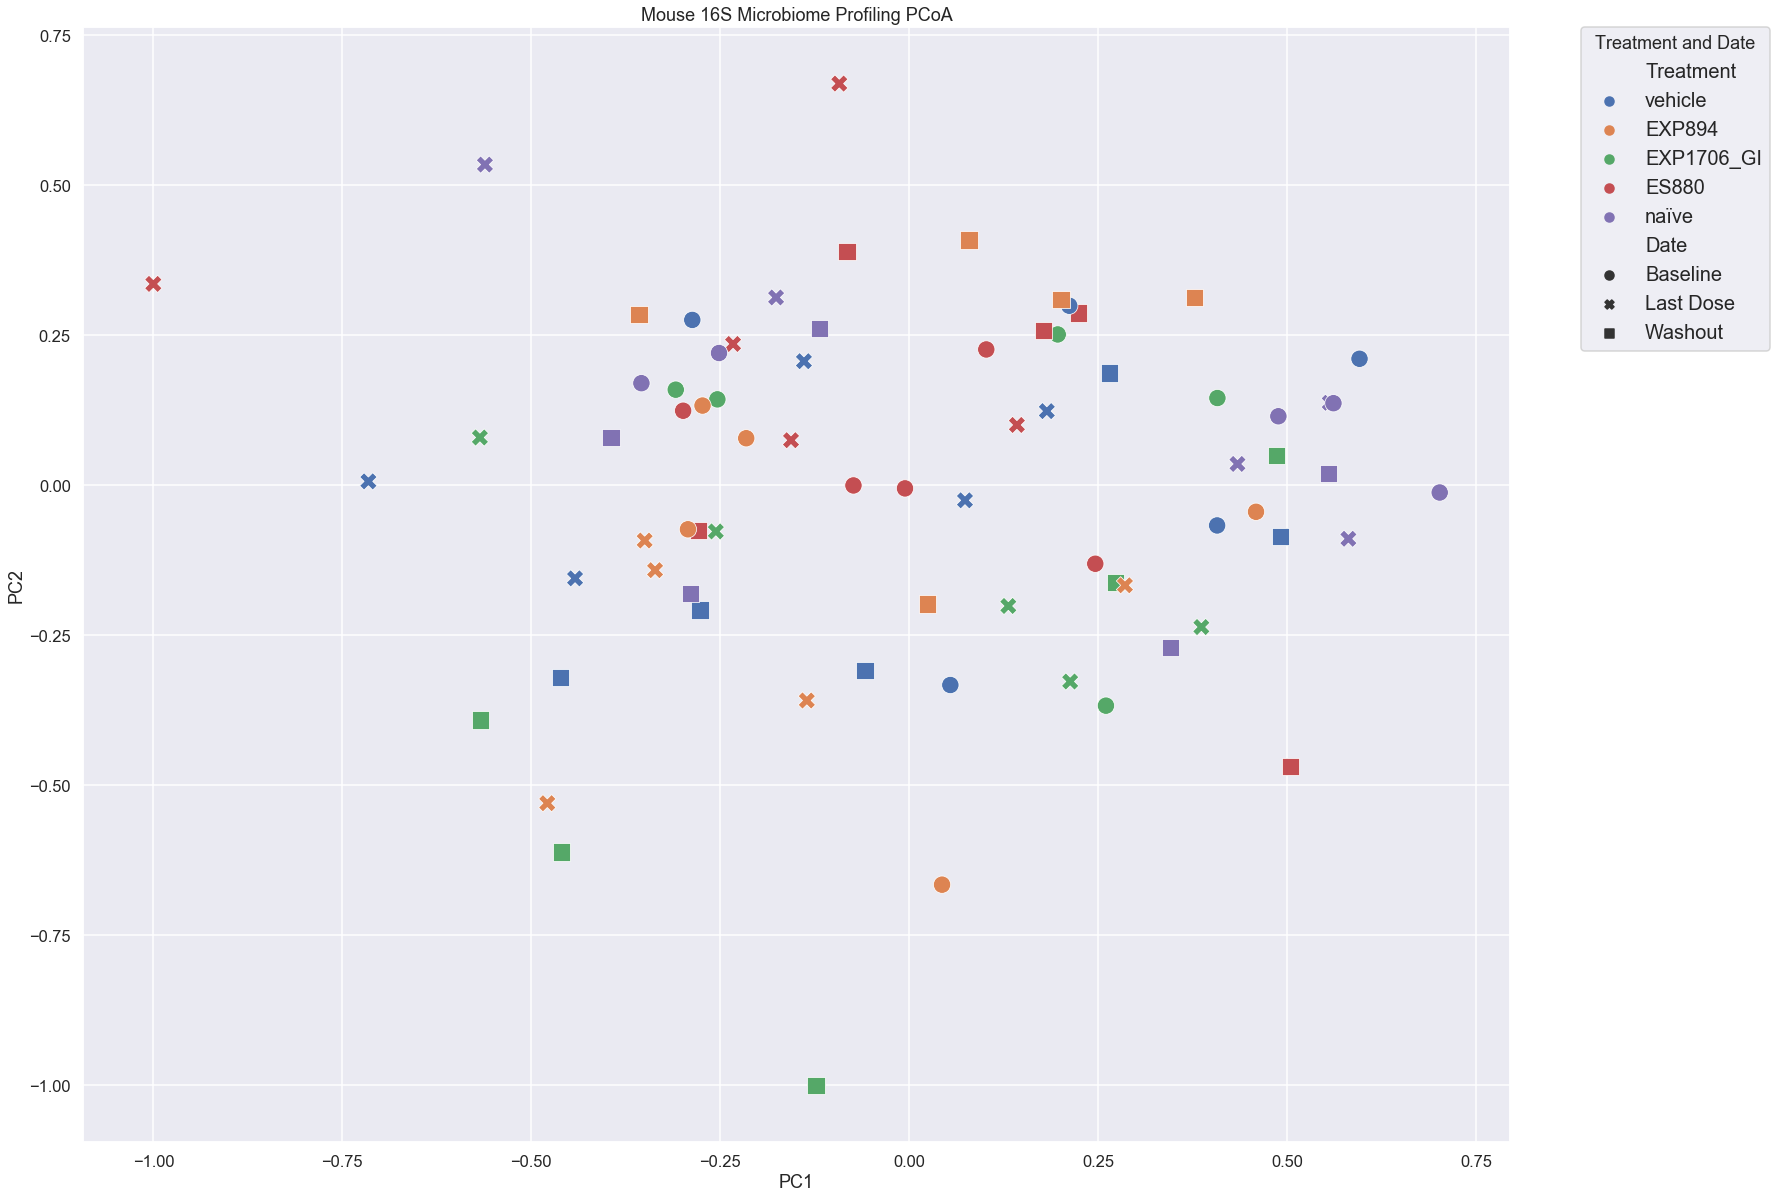

In [49]:
"""Getting plotting data and generating plot for pco by treatment and timepoint"""
pco_plotting = pco_data.merge(ancom_metadata, left_index=True, right_index=True, how='left')

pco_plotting.rename(columns={'description':'TimePoint','drug':'Treatment'}, inplace=True)
cohort_df.sort_values(by=['external_sample_id', 'Date'], inplace=True)
fig, ax = plt.subplots(figsize=(25,17))
sns.scatterplot(cohort_df['PC1'], cohort_df['PC2'], hue=cohort_df['Treatment'], style=cohort_df['TimePoint'], s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, title='Treatment and TimePoint', prop={'size':20})
plt.title('16S Microbiome Profiling PCoA by Treatment and Timepoint')

plt.tight_layout()
plt.savefig(results_dir + 'plots/all_pcoa.png')


In [ ]:
"""Creating radial bar plots by individual subject for each timepoint with top 25 genera"""
def get_radial_plotting_df(ancom_df):    
    """get and sort by totals"""
    ancom_df['totals'] = ancom_df.sum(axis=1)
    ancom_df.index.name = 'genus'
    ancom_df.sort_values(ascending=False, by='totals', inplace=True)
    """Convert to percentages"""
    cols = ancom_df.columns.tolist()
    percent_frame = ancom_df[cols].div(ancom_df[cols].sum(axis=0), axis=1).multiply(100).copy()
    percent_frame.reset_index(inplace=True)
    top_25_df = percent_frame.head(25)
    """calculate theta values"""
    top_25_df['theta'] = (2 * np.pi / len(top_25_df['genus'])) * top_25_df.index
    return top_25_df

radial_plotting_df = get_radial_plotting_df(ancom_df)
subject_list = samples.metadata[['external_sample_id']].unique().astype(str).tolist()


In [ ]:
def plot_radials(subject_list, dataframe, start, color_map):
    """setting global parameters"""
    sns.set(style='white', context='talk')
    width = .3
    bottom = 20
    """by adjusting the first item in the linespace call, we can change where on the colormap things start. However things must 
    stay between 0 and 1, else everything outside that range will be the same color"""
    color_idx = np.linspace(start, 1, 25)
    """Different colormap options"""
#     my_cmap = plt.cm.get_cmap('nipy_spectral')
#     my_cmap = plt.cm.get_cmap('tab20c')
#     my_cmap = plt.cm.get_cmap('gist_ncar')
#     my_cmap = plt.cm.get_cmap('hsv')
#     my_cmap = plt.cm.get_cmap('gist_rainbow')
    """Seaborn colormaps"""
#     my_cmap = ListedColormap(sns.color_palette('Spectral_r', n_colors=25, desat=.8))
    my_cmap = plt.cm.get_cmap(color_map)
    colors = my_cmap(color_idx)
    timepoints = ['x', 'y', 'z']

    """looping through subjects and saving individual figures to one final pdf"""
    pdf = matplotlib.backends.backend_pdf.PdfPages(results_dir + '16s_combined_radials.pdf')
    for subject_id in subject_list:
        legend_list = dataframe['genus']
        fig = plt.figure(figsize=(15,10)) # Notice the equal aspect ratio
        ax1, ax2, ax3 = [fig.add_subplot(3,3,i+1, polar=True) for i in range(3)]
        #plt.figure(figsize=(20,10))
        #ax1 = plt.subplot(331, polar=True)
        #ax2 = plt.subplot(332, polar=True)
        #ax3 = plt.subplot(333, polar=True)
        axes = [ax1, ax2, ax3]
        gs1 = gridspec.GridSpec(1, 3)
        gs1.update(wspace=0.0, hspace=0.0)
        """batching axes setup"""
        for ax in axes:
            ax.set_theta_direction(-1)
            ax.set_theta_zero_location('NE')
            ax.set_rlabel_position(340)
            #ax.set_rgrids(labels=['', '10', '20', '30'], rotation='vertical')
            #ax.set_rgrids([10, 30, 40, 50], labels=['', '10', '20', '30'], rotation='vertical')
            

            ax.tick_params(labelsize=10, rotation='auto')
            ax.set_thetagrids([], labels=[])
            ax.spines['polar'].set_visible(False)
        for i in range(len(timepoints)):       
            for x,y,c,lb in zip(dataframe['theta'], dataframe[str(subject_id + timepoints[i])], colors, legend_list):
                axes[i].bar(x, y, color=c,label=lb, width=.25, bottom=50, linewidth=0)
            axes[i].set_rgrids([60, 70, 80, 90], labels=['10', '20', '30', '40'], rotation='vertical')
            axes[i].set_aspect('equal')
        
        """Creating Global Legend"""
        ax1.legend(loc=(1.43, 1.1), ncol=5, prop={'size': 8})
        ax1.set_title(str('Subject ' + subject_id + '\n 16S Microbiome Profile'), y=1.1)
        ax1.set_xlabel('Day X', y=-.2)
        ax2.set_xlabel('Day Y', y=-.2)
        ax3.set_xlabel('Day Z', y=-.2)
        #ax3.set_xlabel('Washout')
        plt.tight_layout()
        plt.subplots_adjust(wspace=.0, hspace=0)
        plt.savefig(results_dir + 'Subject_' + subject_id + '_radial_bar.png', dpi=300, bbox_inches='tight', pad_inches=.5)
        pdf.savefig()
    pdf.close()
    
plot_radials(subject_list, radial_plotting_df, 0.00, 'nipy_spectral')